In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import pyplot as plt
import geopandas as gpd
import rasterio

from src.geo_util import (
    get_masks, 
    infer_date, 
    group_images_by_date, 
    compute_raster_extent, 
    load_and_merge_masks, 
    rasterize_gdf,
    merged_no_data_mask,
    extract_linestring,
    tif_image,
    plot_mask,
    plot_line,
    plot_crops,
    merge_tifs,
    create_per_day_crops,
)
from src.ml_util import generate_square_crops_along_line

In [2]:
base_path = Path("/Users/kyledorman/data/BorderField/")
classification_dir = base_path / "Classifications"
shp_dir = base_path / "Lines"
    
crop_size = 224
buffer_factor = 0.125
buffer_px = int(crop_size * buffer_factor)
mask_dir = base_path / "Masks"
img_paths = sorted(list(base_path.glob("SatelliteImagery/*/*.tif")))

In [3]:
# Masks and dates
veg_masks = get_masks(mask_dir, "Mask_*.shp")
water_masks = get_masks(mask_dir, "WaterMask_*.shp")
mask_date = infer_date(veg_masks + water_masks)

len(veg_masks), len(water_masks), mask_date

(3, 3, '20170101')

In [4]:
# Group images
groups = group_images_by_date(img_paths)
ref_imgs = groups.pop(mask_date, [])

len(ref_imgs), len(groups)

(3, 311)

In [5]:
# Compute extent & raster masks
out_transform, out_shape, CRS = compute_raster_extent(ref_imgs + sum(groups.values(), []))

out_shape, CRS

((4988, 1454),
 CRS.from_wkt('PROJCS["WGS 84 / UTM zone 11N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-117],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32611"]]'))

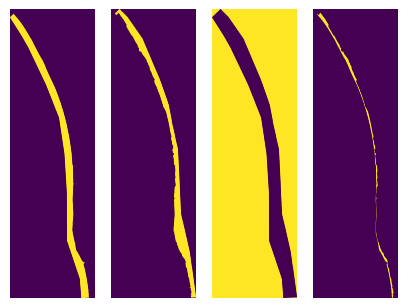

In [7]:
veg_gdf = load_and_merge_masks(veg_masks)
veg_mask = rasterize_gdf(veg_gdf, out_shape, out_transform) == 1
water_gdf = load_and_merge_masks(water_masks)
water_mask = rasterize_gdf(water_gdf, out_shape, out_transform) == 1
full_no_data = merged_no_data_mask(water_mask, veg_mask)
sand_mask = ~(full_no_data | water_mask | veg_mask)

merged_mask = np.zeros(veg_mask.shape, dtype=np.uint8)
merged_mask[water_mask] = 1
merged_mask[veg_mask] = 2
merged_mask[sand_mask] = 3

fig, axes = plt.subplots(1, 4, figsize=(5, 5))
for ax in axes:
    ax.axis('off')
axes[0].imshow(water_mask)
axes[1].imshow(veg_mask)
axes[2].imshow(full_no_data)
axes[3].imshow(sand_mask)

In [8]:
# Extract lines and generate crops
water_line = extract_linestring(water_mask, full_no_data)
assert water_line is not None
veg_line = extract_linestring(veg_mask, full_no_data)
assert veg_line is not None
prompt_crops = generate_square_crops_along_line(water_line, crop_size, 0)

In [9]:
# def affine_to_fn(affine: Affine):
#     return lambda x, y: affine * (x, y)

In [10]:
merged_img, merged_img_nodata = merge_tifs(ref_imgs, out_shape, out_transform, CRS)

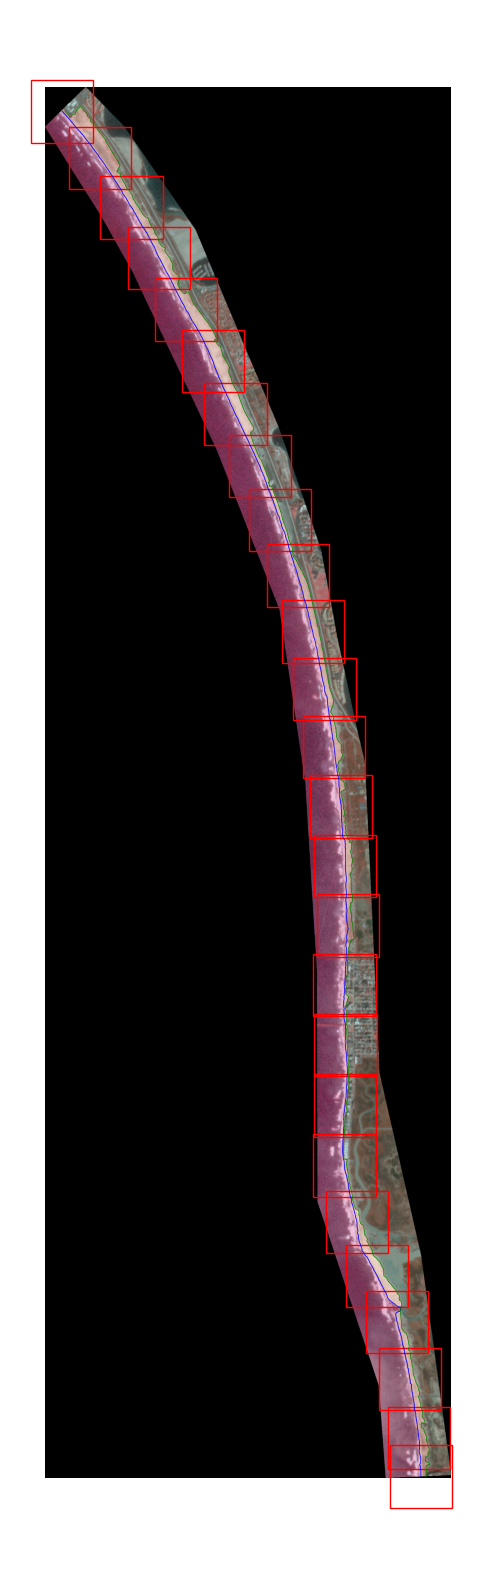

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 16))

ax.imshow(merged_img)
plot_mask(veg_mask, 'teal', 0.3, ax)

plot_mask(water_mask, 'hotpink', 0.3, ax)

plot_line(water_line, 'blue', ax)
plot_line(veg_line, 'green', ax)

plot_crops(prompt_crops, 'red', ax)
        
ax.axis('off')
fig.tight_layout()

In [12]:
p_imgs, p_masks, p_nodata = create_per_day_crops(prompt_crops, merged_img, merged_img_nodata, merged_mask, crop_size)
count = len(p_imgs)
keep = [i for i, nd in enumerate(p_nodata) if ~np.all(nd)]
p_imgs = [p_imgs[i] for i in keep]
p_masks = [p_masks[i] for i in keep]
p_nodata = [p_nodata[i] for i in keep]

len(keep), count

(26, 26)

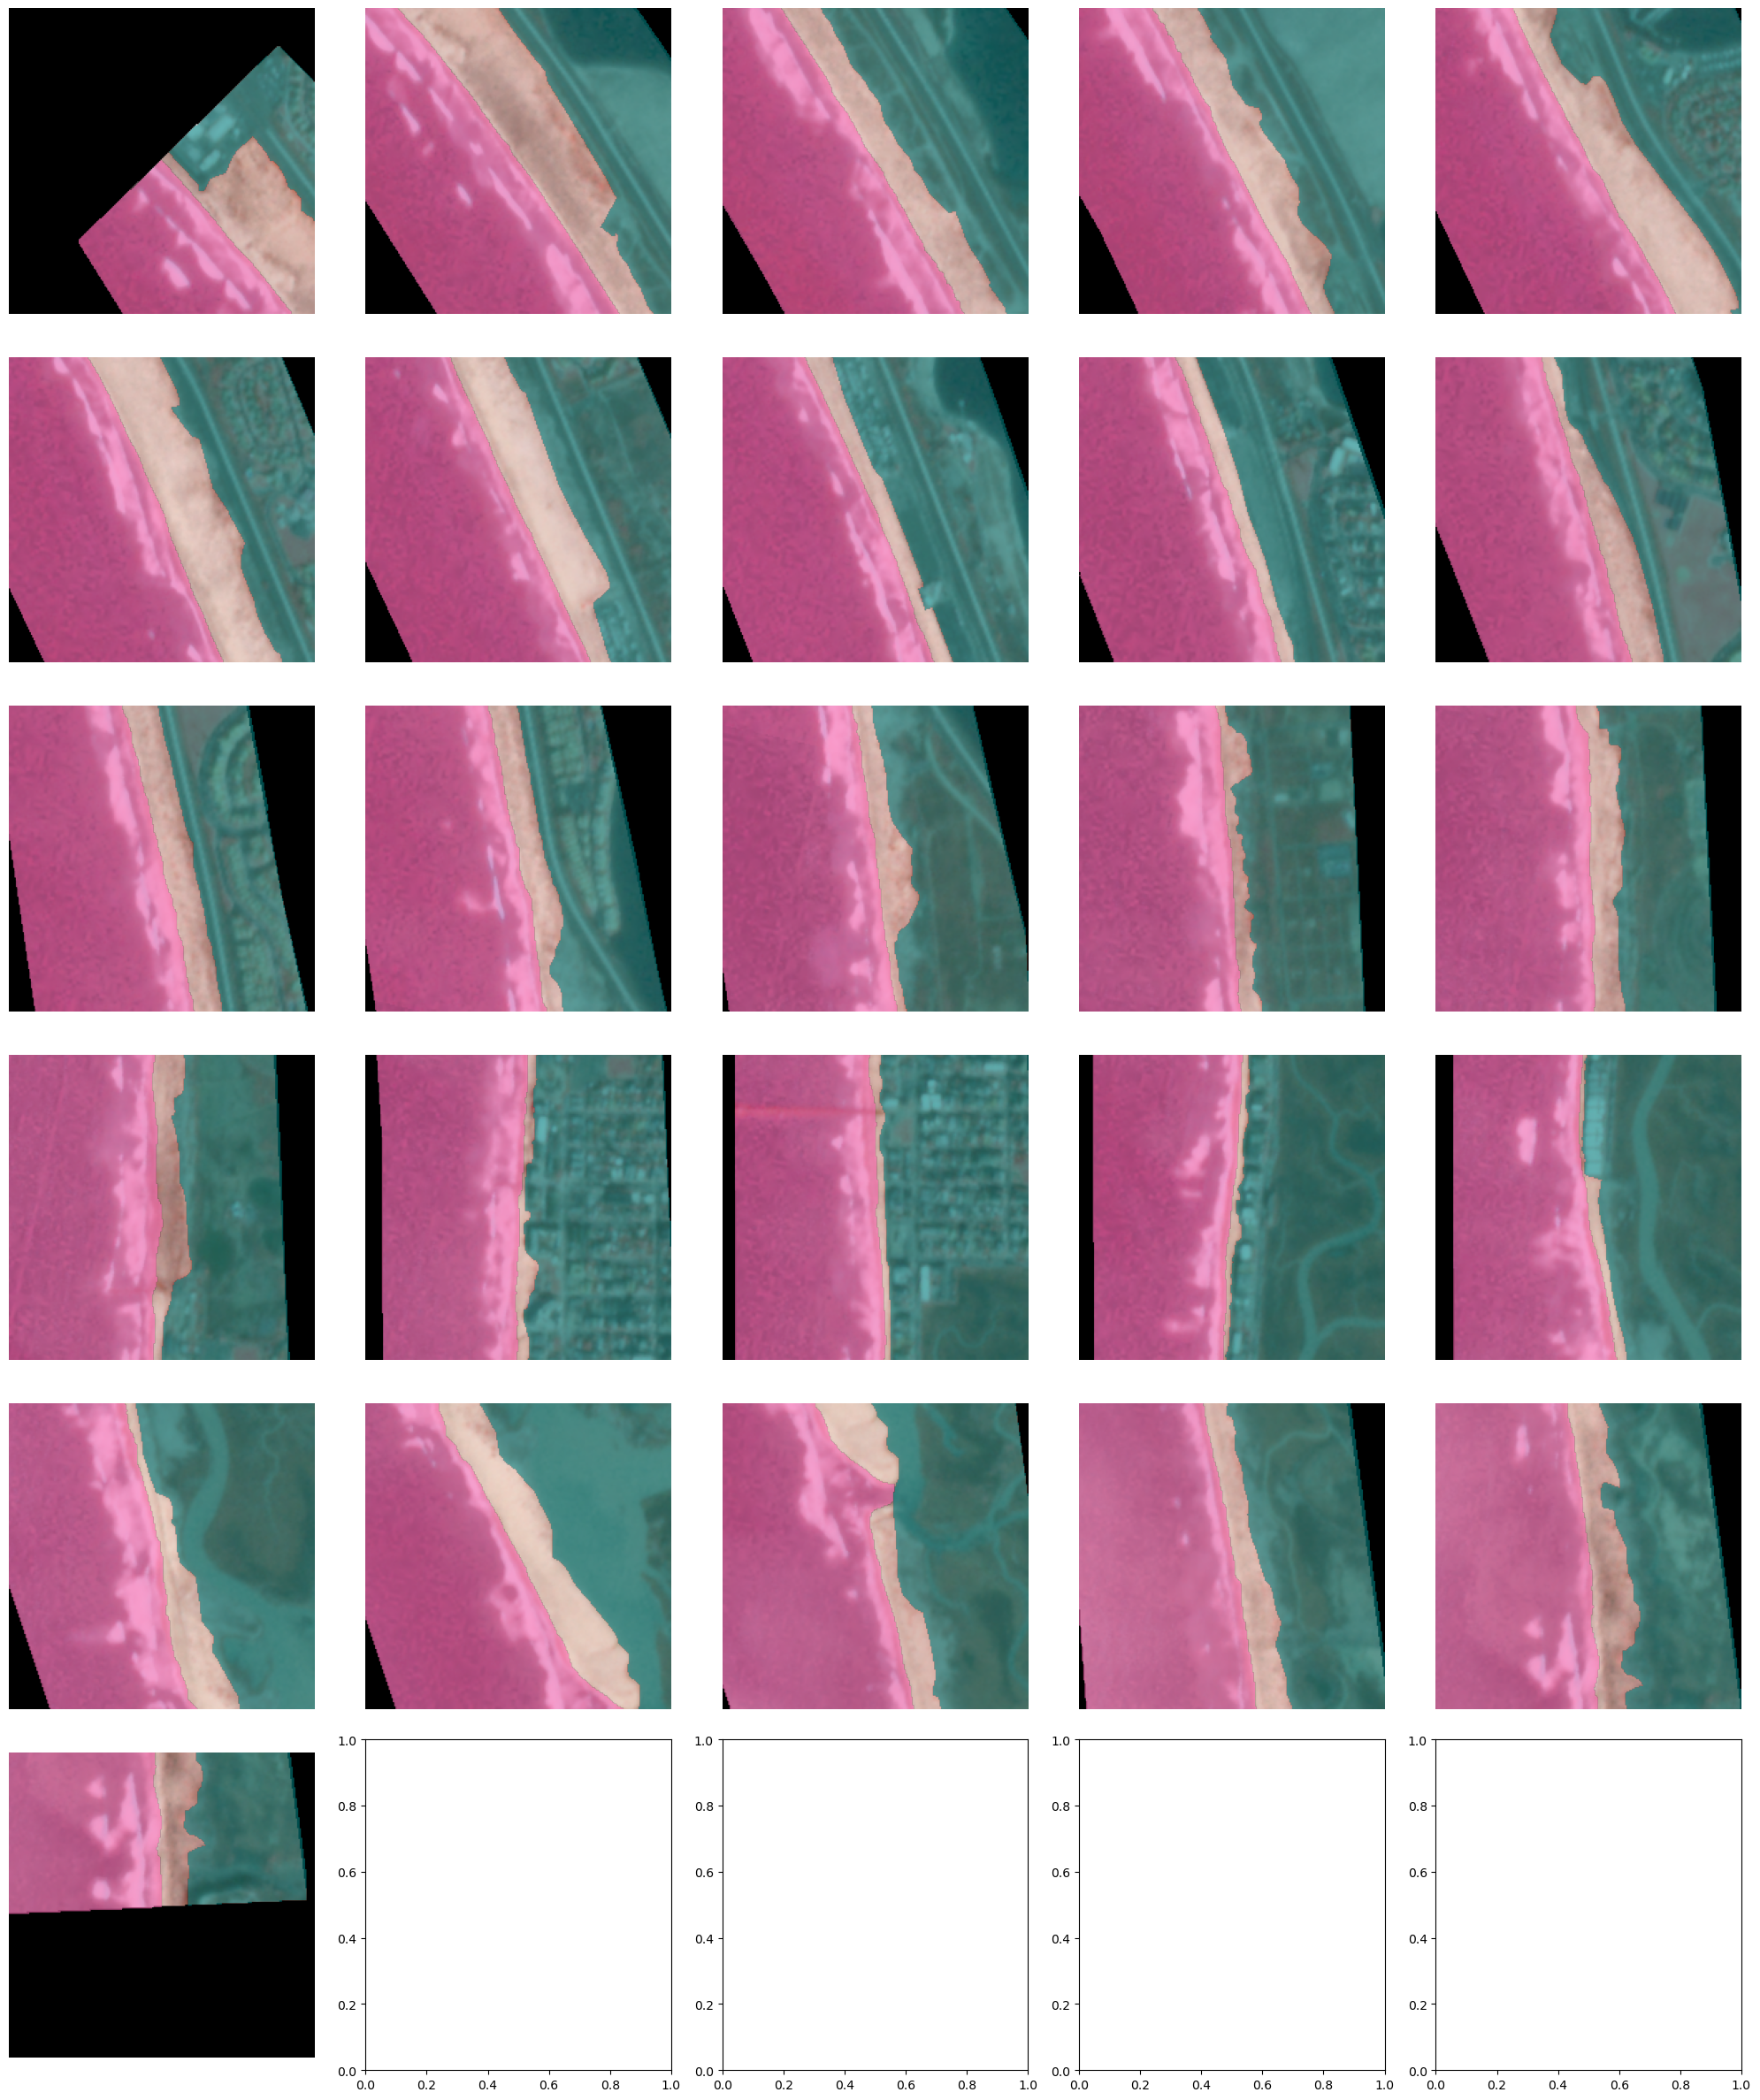

In [14]:
cols = 5
rows = len(p_imgs) // cols + int(len(p_imgs) % cols > 0)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4))
    
for idx, ax in zip(range(len(p_imgs)), axes.flatten()):
    ax.axis('off')
    
    img = p_imgs[idx]    
    ax.imshow(img)
    
    plot_mask(p_masks[idx] == 1, 'hotpink', 0.6, ax)
    plot_mask(p_masks[idx] == 2, 'teal', 0.6, ax)

fig.tight_layout()
plt.show()

In [ ]:
from transformers import SegGptForImageSegmentation, SegGptImageProcessor
from transformers.models.seggpt.modeling_seggpt import SegGptImageSegmentationOutput

checkpoint = "BAAI/seggpt-vit-large"
image_processor = SegGptImageProcessor.from_pretrained(checkpoint)
    
ckpt = torch.load("/Users/kyledorman/data/BorderField_test/prompt.pt", map_location="cpu")
prompt_img_tensors: torch.Tensor = ckpt["prompt_pixel_values"]
prompt_mask_tensors: torch.Tensor = ckpt["prompt_masks"]

print(prompt_img_tensors.shape)
print(prompt_mask_tensors.shape)

if prompt_img_tensors.ndim == 3:
    prompt_img_tensors = prompt_img_tensors.unsqueeze(0)
    prompt_mask_tensors = prompt_mask_tensors.unsqueeze(0)
    
batch_out = SegGptImageSegmentationOutput(pred_masks=prompt_mask_tensors)
    
masks = image_processor.post_process_semantic_segmentation(
    batch_out, 
    target_sizes=[tuple(prompt_img_tensors.shape[2:]) for _ in range(len(prompt_img_tensors))], 
    num_labels=3
)

# To unnormalize we need to permute to channel last
# batch_size x height x width x num_channels
std = torch.tensor(image_processor.image_std).to(prompt_img_tensors.device)
mean = torch.tensor(image_processor.image_mean).to(prompt_img_tensors.device)

prompt_img_tensors = prompt_img_tensors.permute(0, 2, 3, 1) * std + mean
prompt_img_tensors = prompt_img_tensors.permute(0, 3, 1, 2)
prompt_img_tensors = torch.clip(prompt_img_tensors * 255, 0, 255)


rows = len(prompt_img_tensors)
fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(2 * 5, rows * 5))
if rows == 1:
    axes = [axes]

for r in range(rows):
    prompt_img = prompt_img_tensors[r].permute(1, 2, 0).numpy().astype(np.uint8)

    axes[r][0].imshow(prompt_img)
    axes[r][1].imshow(masks[r].numpy().astype(np.uint8), cmap='tab10')

fig.tight_layout()
plt.show()

In [ ]:
groups_img_iter = iter(groups.items())
# veg_crops = generate_square_crops_along_line(veg_line, crop_size, int(crop_size / 2))
crops = generate_square_crops_along_line(water_line, crop_size, 0)

len(crops)

In [ ]:
date, tif_paths = next(groups_img_iter)

# --- Precompute the inverse of out_transform ---
inv_transform = ~out_transform  # Inverts Affine, world -> pixel

date_water_line = None
if (shp_dir / "WetDryLine" / f"{date}.shp").exists():
    # --- Load the shapefile ---
    line_water_gdf = gpd.read_file(shp_dir / "WetDryLine" / f"{date}.shp")
    assert len(line_water_gdf) == 1, "Expected exactly one line"
    assert line_water_gdf.crs == CRS
    date_water_line = shapely_transform(affine_to_fn(inv_transform), line_water_gdf.geometry.iloc[0])
    
date_veg_line = None
if (shp_dir / "VegLine" / f"{date}.shp").exists():
    # --- Load the shapefile ---
    line_veg_gdf = gpd.read_file(shp_dir / "VegLine" / f"{date}.shp")
    assert len(line_veg_gdf) == 1, "Expected exactly one line"
    assert line_veg_gdf.crs == CRS
    date_veg_line = shapely_transform(affine_to_fn(inv_transform), line_veg_gdf.geometry.iloc[0])
    
if date_water_line is None:
    print("No water line for", date)
if date_veg_line is None:
    print("No veg line for", date)

with rasterio.open(classification_dir / "WetDryLine" / f"{date}.tif") as src:
    date_water_mask = src.read(1) == 1
with rasterio.open(classification_dir / "VegLine" / f"{date}.tif") as src:
    date_veg_mask = src.read(1) == 1
    
_, _, _, date_no_data = create_per_day_crops(
    crops, out_transform, tif_paths, merged_mask, crop_size
)
date_sand_mask = ~date_no_data & ~date_water_mask & ~date_veg_mask
date_merged_mask = np.zeros(date_water_mask.shape, dtype=np.uint8)
date_merged_mask[date_water_mask] = 1
date_merged_mask[date_veg_mask] = 2
date_merged_mask[date_sand_mask] = 3
    
crop_imgs, crop_masks, crop_nodatas, _ = create_per_day_crops(
    crops, out_transform, tif_paths, date_merged_mask, crop_size
)

keep_idx = [idx for idx, nodata in enumerate(crop_nodatas) if np.any(~nodata)]

cols = 3
rows = len(keep_idx) // cols + int(len(keep_idx) % 3 > 0)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 6, rows * 6))

    
for idx, ax in zip(keep_idx, axes.flatten()):
    ax.axis('off')
    
    img = crop_imgs[idx]    
    ax.imshow(img)
    
    plot_mask(crop_masks[idx] == 1, 'hotpink', 0.6, ax)
    plot_mask(crop_masks[idx] == 2, 'teal', 0.6, ax)
#     plot_mask(crop_masks[idx] == 3, 'yellow', 0.6, ax)
    
    xmin, ymin, xmax, ymax = crops[idx]
    # --- Clip the line to the crop bounds ---
    crop_box = shapely.geometry.box(xmin, ymin, xmax, ymax)
    
    if date_water_line is not None:
        clipped = date_water_line.intersection(crop_box)
        if not clipped.is_empty:
            # Move to crop local coordinates (0,0 at top-left of crop)
            cropped_line = shapely_transform(lambda x, y: (x - xmin, y - ymin), clipped)
            
            plot_line(cropped_line, 'blue', ax, linewidth=2)
            
    if date_veg_line is not None:
        clipped = date_veg_line.intersection(crop_box)
        if not clipped.is_empty:
            # Move to crop local coordinates (0,0 at top-left of crop)
            cropped_line = shapely_transform(lambda x, y: (x - xmin, y - ymin), clipped)
            
            plot_line(cropped_line, 'green', ax, linewidth=2)
    
print(date)
fig.tight_layout()
plt.show()